## Data Science for Finance - Computational Finance
### Group Assignment 2023-2024

Amina Baklizi - 20230515@novaims.unl.pt <br>
Malik Harrak - 20231140@novaims.unl.pt <br>
Saad Islam - 20230513@novaims.unl.pt <br>
Hugo Laginha - 20231130@novaims.unl.pt <br>

In [1]:
#importation of camelot package for extracting tables from the pdf file of the assignment
# it should be used pip install camelot-py[cv] but also possible with pdfplumber or tabula packages
import camelot
import pdfplumber

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#numpy_financial package to use the function npf.irr for ytm calculation
import numpy_financial as npf

from scipy import optimize

In [5]:
#extraction of the table in the pdf file with the project description
#Note: we assume the pdf file is saved in the same directory as the current project
# If not in the same folder, a path should be given

file = 'FIS Group Project 2023-24.pdf'

try:
    tables = camelot.read_pdf(file)
    table = tables[0].df
    #table.set_index(0, inplace = True)
    #table.index.name = None
    #table.columns = table.iloc[0].str.replace('\n', '')
    #table = table[1:]
    df = table
except:
    with pdfplumber.open(file) as pdf:
        first_page = pdf.pages[0]
        table = first_page.extract_table()
        #filtered_table = [[item for item in sublist if item is not None and item != ""] for sublist in table]
        #df = pd.DataFrame(filtered_table[2:], columns=filtered_table[0])
        #df = df.set_index('Bond')

#column name change for manipulation purposes
#df.columns = ["Coupon", "Frequency", "Maturity_y", "Dirty_Price"]

In [6]:
df

,0,1
0,Notional amount,25000
1,Coupon Type,Fixed
2,Coupon rate,6.75%
3,Coupon frequency,Semi-annual
4,Currency,USD
5,Issue Date,31/7/2020
6,Maturity Date,21/7/2025
7,Trade Date,18/09/2020
8,Settlement Lag,T+1
9,Day Count,ACT/ACT


**1. [15.0] Consider the following bond market information for a set of Treasury government bonds:**

In [3]:
df

,Coupon,Frequency,Maturity_y,Dirty_Price
1,"1,50%",Annual,1,"96,60"
2,"1,75%",Annual,2,"93,71"
3,"2,00%",Annual,3,"91,56"
4,"2,25%",Annual,4,"90,24"
5,"2,50%",Annual,5,"89,74"
6,"2,75%",Annual,6,"90,04"
7,"3,00%",Annual,7,"91,09"
8,"3,25%",Annual,8,"92,82"
9,"3,50%",Annual,9,"95,19"
10,"3,75%",Annual,10,"98,14"


**Tasks**
<br>
<br>
a) [1.0] Build a class called YieldCurve that will receive an array with information on 
maturity, price and coupon for n bonds (n x 3)<br>
b) [2.0] Add a method that will bootstrap the discount factors using matrix operations <br>
c) [2.0] Add a method that will bootstrap the discount factors using a global solver <br>
d) [2.0] Add a method that will bootstrap the discount factors using an iterative procedure

In [4]:
'''a) [1.0] Build a class called YieldCurve that will receive an array with information on maturity,
price and coupon for n bonds (n x 3)'''

#Creation of the Class YieldCurve receiving n x 3 array and subsequent creation of three vectors,
#for maturity, price and coupon for better manipulation within the methods

class YieldCurve(object):
    def __init__ (self, bond_data):
        self.bond_data = bond_data
        self.maturities, self.prices, self.coupons = self.bond_data[:, 0], self.bond_data[:, 1], self.bond_data[:, 2]
        self.maturities = self.maturities.astype(int)

#Method to calculate the Cash-Flows matrix to then be used in the different bootstrapping methods
#for calculating the Discount Factors

    def cfs (self):
        CFs = np.zeros((len(self.bond_data), len(self.bond_data)))
        for i, bond in enumerate(self.bond_data):
            maturity, price, coupon = bond
            for year in range(1, max(self.maturities) + 1):
                if year < maturity:
                    CFs[i, year - 1] = coupon
                elif year == maturity:
                    CFs[i, year - 1] = coupon + 100
        return CFs
    
    
    '''b) [2.0] Add a method that will bootstrap the discount factors using matrix operations '''
    
    def DFs_bootstrap_matrix (self):
        CFs = self.cfs()
        DFs = np.linalg.inv(CFs) @ self.prices
        return DFs
    
    
    '''c) [2.0] Add a method that will bootstrap the discount factors using a global solver '''    
    
    def DFs_bootstrap_global_solver (self):
        CFs = self.cfs()
        def objective_function(dfs):
            calculated_prices = np.dot(CFs, dfs)
            return np.sum((calculated_prices - self.prices) ** 2)
        initial_guess = np.ones(len(self.bond_data))  
        result = optimize.minimize(objective_function, initial_guess)
        DFs = result.x
        return DFs

    '''d) [2.0] Add a method that will bootstrap the discount factors using an iterative procedure'''
    
    def DFs_bootstrap_iterative(self):
        n = len(self.bond_data)
        zeros = np.zeros(n)
        for bond in self.bond_data:
            maturity, price, coupon = bond
            coupon /= 100
            maturity = int(maturity)
            known_cf = sum([coupon/(1+zeros[n])**(n+1) for n in range(maturity -1)]) * 100
            f = lambda z : known_cf + ((1 + coupon) * 100)/(1+z)**maturity - price
            zero = optimize.newton(f, 0)
            zeros[int(maturity)-1] = zero
            DFs = np.array([1/(1+z)**(n+1) for n,z in enumerate(zeros)])
        return DFs

In [5]:
#transformation of the initial dataframe to a more suitable form for latter manipulations and creation
# of a numpy array of the structure needed to be used taken as argument into our class and respective methods

#change the order of the columns into maturity, price and coupon as described in task a of the project sheet

df = df.iloc[:, [0, 2, 3]].copy()
cols = df.columns.tolist()
cols = cols[1:] + cols[:1]
df = df[cols]
df

,Maturity_y,Dirty_Price,Coupon
Bond,,,
1,1,"96,60","1,50%"
2,2,"93,71","1,75%"
3,3,"91,56","2,00%"
4,4,"90,24","2,25%"
5,5,"89,74","2,50%"
6,6,"90,04","2,75%"
7,7,"91,09","3,00%"
8,8,"92,82","3,25%"
9,9,"95,19","3,50%"


In [6]:
#transforming data from string to float and removing the percentage symbol

df[df.columns[0]] = df[df.columns[0]].astype(int)
df[df.columns[1]] = df[df.columns[1]].str.replace(',', '.').astype(float)
df[df.columns[2]] = df[df.columns[2]].str.rstrip('%').str.replace(',', '.').astype(float)

df

,Maturity_y,Dirty_Price,Coupon
Bond,,,
1,1,96.60,1.50
2,2,93.71,1.75
3,3,91.56,2.00
4,4,90.24,2.25
5,5,89.74,2.50
6,6,90.04,2.75
7,7,91.09,3.00
8,8,92.82,3.25
9,9,95.19,3.50


In [10]:
#creation of an array to be used inside our class and class specific methods

data_array = np.array(df)
data_array

array([[ 1.  , 96.6 ,  1.5 ],
       [ 2.  , 93.71,  1.75],
       [ 3.  , 91.56,  2.  ],
       [ 4.  , 90.24,  2.25],
       [ 5.  , 89.74,  2.5 ],
       [ 6.  , 90.04,  2.75],
       [ 7.  , 91.09,  3.  ],
       [ 8.  , 92.82,  3.25],
       [ 9.  , 95.19,  3.5 ],
       [10.  , 98.14,  3.75]])

In [11]:
#initiation of an object of the class YieldCurve named yc, with the information from our initial df
# provided by the data_array

yc = YieldCurve(data_array)

In [12]:
yc.DFs_bootstrap_matrix()

array([0.95172414, 0.90461408, 0.86124827, 0.8227426 , 0.78916271,
       0.76042723, 0.73611886, 0.71559687, 0.69849544, 0.68423626])

In [13]:
yc.DFs_bootstrap_global_solver()

array([0.95172413, 0.90461408, 0.86124826, 0.82274259, 0.7891627 ,
       0.76042722, 0.73611886, 0.71559686, 0.69849544, 0.68423625])

In [14]:
yc.DFs_bootstrap_iterative()

array([0.95172414, 0.90461408, 0.86124827, 0.8227426 , 0.78916271,
       0.76042723, 0.73611886, 0.71559687, 0.69849544, 0.68423626])

In [15]:
#adding a column for the Discount Factors to our DataFrame, using one of the class methods, for subsequent tasks

dfs = yc.DFs_bootstrap_matrix()
df["Discount_Factors"] = dfs
df

,Maturity_y,Dirty_Price,Coupon,Discount_Factors
Bond,,,,
1,1,96.60,1.50,0.951724
2,2,93.71,1.75,0.904614
3,3,91.56,2.00,0.861248
4,4,90.24,2.25,0.822743
5,5,89.74,2.50,0.789163
6,6,90.04,2.75,0.760427
7,7,91.09,3.00,0.736119
8,8,92.82,3.25,0.715597
9,9,95.19,3.50,0.698495


**Task**
<br>
<br>
e) [2.0] Determine the spot rate (annual compounding) for each maturity from the calculated discount factors and plot them

In [16]:
# We can calculate this directly by creating the below variable
sp = ((1 / dfs) ** (1/data_array[: , 0])) - 1
sp

array([0.05072464, 0.05140086, 0.05105122, 0.0499872 , 0.04849579,
       0.04670361, 0.04473811, 0.04271698, 0.04067509, 0.03867431])

In [17]:
# But we can also create a method for the class YieldCurve outside of its definition
def Spot_Rates(self):
    DFs = self.DFs_bootstrap_matrix()
    return ((1 / DFs) ** (1/self.bond_data[: , 0])) - 1

YieldCurve.Spot_Rates = Spot_Rates

In [18]:
#Confirming our function is a method of the Class YieldCurve
dir(YieldCurve)

['DFs_bootstrap_global_solver',
 'DFs_bootstrap_iterative',
 'DFs_bootstrap_matrix',
 'Spot_Rates',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'cfs']

In [19]:
yc.Spot_Rates()

array([0.05072464, 0.05140086, 0.05105122, 0.0499872 , 0.04849579,
       0.04670361, 0.04473811, 0.04271698, 0.04067509, 0.03867431])

In [20]:
df['Spot_Rates'] = yc.Spot_Rates()
df

,Maturity_y,Dirty_Price,Coupon,Discount_Factors,Spot_Rates
Bond,,,,,
1,1,96.60,1.50,0.951724,0.050725
2,2,93.71,1.75,0.904614,0.051401
3,3,91.56,2.00,0.861248,0.051051
4,4,90.24,2.25,0.822743,0.049987
5,5,89.74,2.50,0.789163,0.048496
6,6,90.04,2.75,0.760427,0.046704
7,7,91.09,3.00,0.736119,0.044738
8,8,92.82,3.25,0.715597,0.042717
9,9,95.19,3.50,0.698495,0.040675


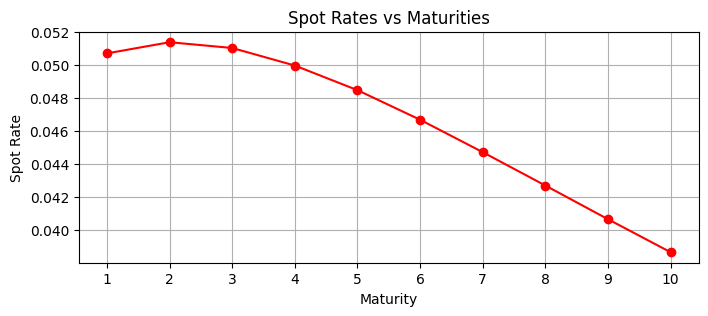

In [22]:
plt.figure(figsize = (8, 3))
plt.plot(df['Spot_Rates'], marker = "o", color = 'r')
plt.title('Spot Rates vs Maturities')
plt.xlabel('Maturity')
plt.ylabel('Spot Rate')
plt.grid()
plt.show()

**Task**
<br>
<br>
f) [2.0] Determine the YTM for each bond and plot them

In [23]:
# This task can be solved through the definition of a method using the Newton-Raphson's method
def bond_ytm(self, maturity, price, coupon):
    ytm_func = lambda y : sum([(coupon if n < maturity else coupon + 1)/(1+y)**n
                               for n in range(1, maturity +1)]) * 100 - price
    return optimize.newton(ytm_func, 0)


def BOND_YTM(self):
    ylds = []
    for bond in self.bond_data:
        maturity, price, coupon = bond
        ylds.append(self.bond_ytm(int(maturity), price, coupon/100))
    return ylds


YieldCurve.bond_ytm = bond_ytm
YieldCurve.BOND_YTM = BOND_YTM

In [24]:
# Another possible method is through the use of the IRR function from Numpy_Financial
def YTM_NPF_IRR(self):
    data = np.column_stack((-np.array(self.prices), self.cfs()))
    yields = [npf.irr(bond) for bond in data]
    return yields

YieldCurve.YTM_NPF_IRR = YTM_NPF_IRR

In [25]:
df['YTM'] = yc.YTM_NPF_IRR()
df

,Maturity_y,Dirty_Price,Coupon,Discount_Factors,Spot_Rates,YTM
Bond,,,,,,
1,1,96.60,1.50,0.951724,0.050725,0.050725
2,2,93.71,1.75,0.904614,0.051401,0.051395
3,3,91.56,2.00,0.861248,0.051051,0.051054
4,4,90.24,2.25,0.822743,0.049987,0.050026
5,5,89.74,2.50,0.789163,0.048496,0.048607
6,6,90.04,2.75,0.760427,0.046704,0.046931
7,7,91.09,3.00,0.736119,0.044738,0.045127
8,8,92.82,3.25,0.715597,0.042717,0.043311
9,9,95.19,3.50,0.698495,0.040675,0.041514


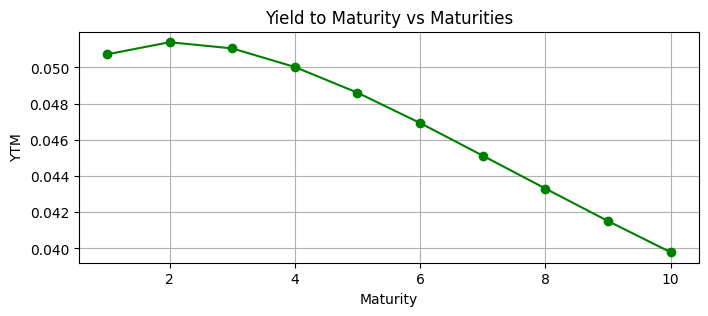

In [26]:
plt.figure(figsize = (8, 3))
plt.plot(df['Maturity_y'], df['YTM'], marker = "o", color = 'g')
plt.title('Yield to Maturity vs Maturities')
plt.xlabel('Maturity')
plt.ylabel('YTM')
plt.grid()
plt.show()

**Task**
<br>
<br>
g) [2.0] Determine the 1y forward rate starting in each of the years from 1 to 9 and plot them

In [27]:
#Definition of a method to calculate the ONE Y FWD RATE
def ONE_Y_FWD_RATE(self):
    forward_rates = []
    spot_rates = self.Spot_Rates()
    n = len(spot_rates)
    
    for t in range(n - 1):
        forward_rate = ((1 + spot_rates[t + 1]) ** (t + 1)  / ((1 + spot_rates[t]) ** t) - 1)
        forward_rates.append(forward_rate)
    return forward_rates

YieldCurve.ONE_Y_FWD_RATE = ONE_Y_FWD_RATE

In [28]:
df['1Y_Forward_Rate'] = yc.ONE_Y_FWD_RATE() + [None]
df

,Maturity_y,Dirty_Price,Coupon,Discount_Factors,Spot_Rates,YTM,1Y_Forward_Rate
Bond,,,,,,,
1,1,96.60,1.50,0.951724,0.050725,0.050725,0.051401
2,2,93.71,1.75,0.904614,0.051401,0.051395,0.050702
3,3,91.56,2.00,0.861248,0.051051,0.051054,0.047862
4,4,90.24,2.25,0.822743,0.049987,0.050026,0.044034
5,5,89.74,2.50,0.789163,0.048496,0.048607,0.039566
6,6,90.04,2.75,0.760427,0.046704,0.046931,0.034966
7,7,91.09,3.00,0.736119,0.044738,0.045127,0.030672
8,8,92.82,3.25,0.715597,0.042717,0.043311,0.026493
9,9,95.19,3.50,0.698495,0.040675,0.041514,0.022806


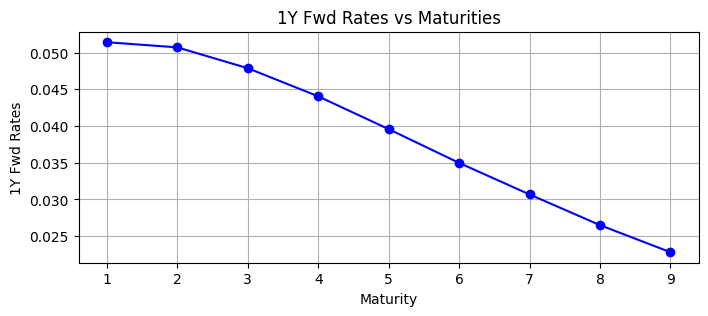

In [29]:
plt.figure(figsize = (8, 3))
plt.plot(df['Maturity_y'], df['1Y_Forward_Rate'], marker = "o", color = 'b')
plt.title('1Y Fwd Rates vs Maturities')
plt.xlabel('Maturity')
plt.ylabel('1Y Fwd Rates')
plt.grid()
plt.show()

**Task**
<br>
<br>
h) [2.0] Make a plot of the spot rates, yields and forward rates with a legend identifying the
series

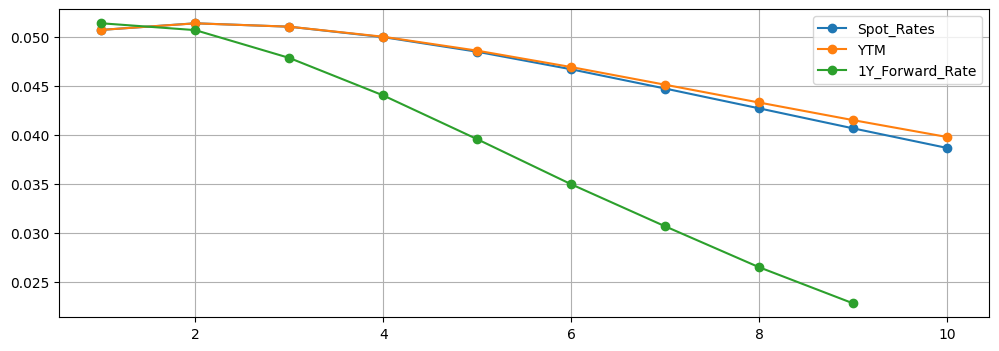

In [30]:
plt.figure(figsize = (12,4))

for col in df.columns[-3:] :
    plt.plot(df['Maturity_y'], df[col], label = col, marker = 'o')

plt.legend()
plt.grid()
plt.show()

**2. [5.0] DataFrames: write python code for the following tasks**

**Task**
<br>
<br>
a) [1.0] Get historical data (close price and volume) for 5 stocks of your choice using any API of
your choice from 2012 to the present time

In [31]:
#Using Yahoo Finance as our API
import yfinance as yf

In [32]:
#Our choice of stocks
stocks = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'KO']

#Time-frame of our historical data download
start_date = '2012-01-01'
end_date = pd.Timestamp.now().strftime('%Y-%m-%d')

In [33]:
#Creation of our DataFrame where we will store the historical data on Close and Volume for each of our stocks
stocks_data = pd.DataFrame()

#Historical data download
for stock in stocks:
    historical_data = yf.Ticker(stock).history(start = start_date, end = end_date)
    historical_data = historical_data[['Close','Volume']]
    historical_data.columns = [f'{stock} - Close', f'{stock} - Vol']
    if stocks_data.empty:
        stocks_data = historical_data
    else: 
        stocks_data = stocks_data.join(historical_data, how = 'outer')

#Definition of the index
stocks_data.index = stocks_data.index.date
stocks_data.index.name = 'Date'

In [34]:
stocks_data

,AAPL - Close,AAPL - Vol,MSFT - Close,MSFT - Vol,GOOGL - Close,GOOGL - Vol,AMZN - Close,AMZN - Vol,KO - Close,KO - Vol
Date,,,,,,,,,,
2012-01-03,12.466093,302220800,21.321222,64731500,16.651901,146912940,8.951500,102216000,24.332636,15639600
2012-01-04,12.533087,260022000,21.822989,80516100,16.723724,114445440,8.875500,84104000,24.179985,14239200
2012-01-05,12.672228,271269600,22.045996,56081400,16.491741,131184684,8.880500,76182000,24.065510,14287600
2012-01-06,12.804705,318292800,22.388466,99455500,16.266768,107608284,9.130500,140168000,23.912867,13646600
2012-01-09,12.784391,394024400,22.093781,59706800,15.577077,232671096,8.928000,101138000,23.912867,10522600
...,...,...,...,...,...,...,...,...,...,...
2023-11-02,177.570007,77334800,348.320007,24348100,127.489998,27124600,138.070007,52236700,57.090000,13087200
2023-11-03,176.649994,79763700,352.799988,23624000,129.100006,26380100,138.600006,44007200,56.740002,13956500
2023-11-06,179.229996,63841300,356.529999,23828300,130.250000,19052700,139.740005,44970400,56.970001,12673200


**Task**
<br>
<br>
b) [1.0] Plot the cumulative returns of the stocks on a single chart

In [35]:
#Slicing the stocks_data DataFrame to retrieve only the close prices and calculating the pct_change
daily_returns = stocks_data.iloc[:, 0::2].pct_change()
daily_returns

,AAPL - Close,MSFT - Close,GOOGL - Close,AMZN - Close,KO - Close
Date,,,,,
2012-01-03,NaN,NaN,NaN,NaN,NaN
2012-01-04,0.005374,0.023534,0.004313,-0.008490,-0.006274
2012-01-05,0.011102,0.010219,-0.013872,0.000563,-0.004734
2012-01-06,0.010454,0.015534,-0.013642,0.028152,-0.006343
2012-01-09,-0.001586,-0.013162,-0.042399,-0.022178,0.000000
...,...,...,...,...,...
2023-11-02,0.020693,0.006502,0.008225,0.007810,0.011517
2023-11-03,-0.005181,0.012862,0.012629,0.003839,-0.006131
2023-11-06,0.014605,0.010573,0.008908,0.008225,0.004054


In [36]:
#Calculation of the cumulative_returns
cumulative_returns = (1 + daily_returns).cumprod() - 1
cumulative_returns

,AAPL - Close,MSFT - Close,GOOGL - Close,AMZN - Close,KO - Close
Date,,,,,
2012-01-03,NaN,NaN,NaN,NaN,NaN
2012-01-04,0.005374,0.023534,0.004313,-0.008490,-0.006274
2012-01-05,0.016536,0.033993,-0.009618,-0.007932,-0.010978
2012-01-06,0.027163,0.050055,-0.023129,0.019997,-0.017251
2012-01-09,0.025533,0.036234,-0.064547,-0.002625,-0.017251
...,...,...,...,...,...
2023-11-02,13.244239,15.336775,6.656183,14.424231,1.346232
2023-11-03,13.170438,15.546893,6.752869,14.483439,1.331848
2023-11-06,13.377399,15.721837,6.821930,14.610792,1.341300


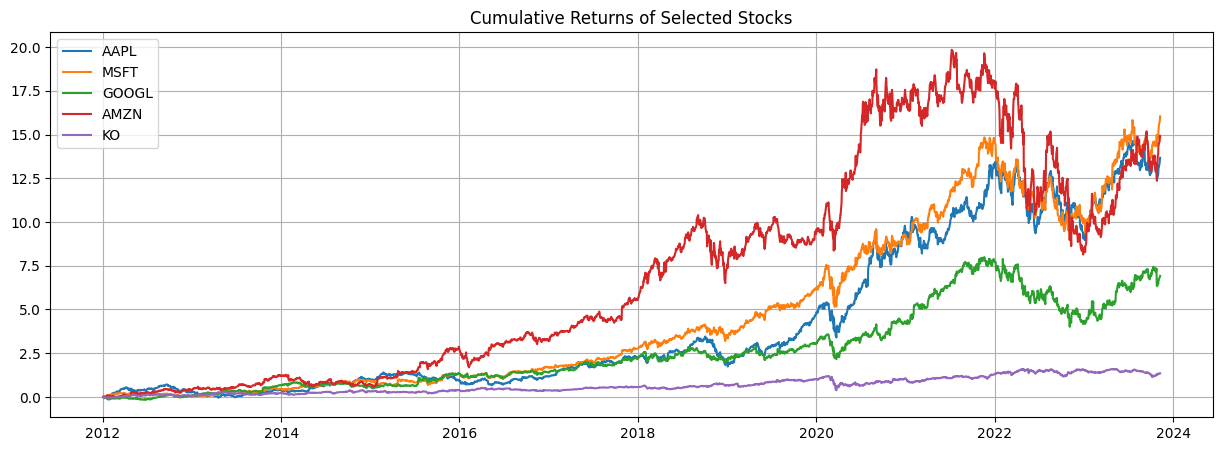

In [37]:
plt.figure(figsize = (15,5))
for stock in cumulative_returns.columns:
    plt.plot(cumulative_returns.index, cumulative_returns[stock], label = stock.split(' - ')[0]) 

plt.title('Cumulative Returns of Selected Stocks')
plt.legend()
plt.grid()
plt.show()

**Task**
<br>
<br>
c) [1.0] Create the correlation matrix of the daily returns

In [38]:
#Definition of the Correlation Matrix  DataFrame
correlation_matrix = daily_returns.corr()
correlation_matrix

,AAPL - Close,MSFT - Close,GOOGL - Close,AMZN - Close,KO - Close
AAPL - Close,1.000000,0.596901,0.552269,0.478915,0.340852
MSFT - Close,0.596901,1.000000,0.653728,0.572595,0.397714
GOOGL - Close,0.552269,0.653728,1.000000,0.607663,0.347110
AMZN - Close,0.478915,0.572595,0.607663,1.000000,0.235026
KO - Close,0.340852,0.397714,0.347110,0.235026,1.000000


In [39]:
#Transformation of the DataFrame into a numpyarray
corr_matrix = correlation_matrix.to_numpy()
corr_matrix

array([[1.        , 0.59690135, 0.55226941, 0.47891521, 0.34085204],
       [0.59690135, 1.        , 0.65372841, 0.57259484, 0.39771398],
       [0.55226941, 0.65372841, 1.        , 0.60766269, 0.34711026],
       [0.47891521, 0.57259484, 0.60766269, 1.        , 0.2350265 ],
       [0.34085204, 0.39771398, 0.34711026, 0.2350265 , 1.        ]])

**Task**
<br>
<br>
d) [1.0] Save the data (close price and volume) to a CSV file for each ticker

In [40]:
#Saving into historical data into seperate csv files
for stock in stocks:
    historical_data = yf.Ticker(stock).history(start = start_date, end = end_date)
    historical_data = historical_data[['Close','Volume']]
    historical_data.index = historical_data.index.date
    historical_data.index.name = 'Date'
    historical_data.to_csv(f'{stock}_hist_data.csv', index = True)

**Task**
<br>
<br>
e) [1.0] Load the data from the CSV files you saved into a single DataFrame with the prices for
each ticker

In [41]:
#Loading info from the different CSV files into one DataFrame
loaded_df = pd.DataFrame()
for stock in stocks:
    new_stock_data = pd.read_csv(f'{stock}_hist_data.csv', index_col = 0)
    new_stock_data = new_stock_data[['Close']]
    new_stock_data.columns = [f'{stock} - Close']
    if loaded_df.empty:
        loaded_df = new_stock_data
    else: 
        loaded_df = loaded_df.join(new_stock_data, how = 'outer')
        
loaded_df

,AAPL - Close,MSFT - Close,GOOGL - Close,AMZN - Close,KO - Close
Date,,,,,
2012-01-03,12.466091,21.321218,16.651901,8.951500,24.332628
2012-01-04,12.533085,21.822983,16.723724,8.875500,24.179987
2012-01-05,12.672232,22.045990,16.491741,8.880500,24.065506
2012-01-06,12.804705,22.388472,16.266768,9.130500,23.912861
2012-01-09,12.784395,22.093784,15.577077,8.928000,23.912861
...,...,...,...,...,...
2023-11-02,177.570007,348.320007,127.489998,138.070007,57.090000
2023-11-03,176.649994,352.799988,129.100006,138.600006,56.740002
2023-11-06,179.229996,356.529999,130.250000,139.740005,56.970001
